# Introdução

Neste projeto foi coletadas letras de músicas do site "vagalume.com.br" com o objetivo de predizer a categoria de uma música baseada na letra. 

As etapas realizadas são:

- Limpeza do texto
- Criação de novas variáveis e manipulações gerais
- Análises descritivas
- Avaliação das categorias de músicas
- Criação do modelo
- Avaliação dos resultados

In [404]:
## Importando bibliotecas
import pandas as pd
import os
import numpy as np

# Pré-Processamento
import re
from unidecode import unidecode 
from spacy.lang.pt.stop_words import STOP_WORDS
from nltk.corpus import stopwords 
import nltk
import string
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Visualização
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import fasttext


# Validação modelo
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score

# ignorando alguns erros
import warnings

In [303]:
# Lendo base
df = pd.read_pickle('../input/songs.pkl')

In [304]:
# Checando quantidade de linhas e colunas
df.shape

(11030, 8)

In [305]:
## Funções para apoio de trativas de textos e criação de variáveis

# Limpa o texto
def transform_text(tokens):
    # html transform
    tokens = tokens.replace('<div data-plugin="googleTranslate" id="lyrics">', '').replace('</div>', '').replace('<br/>', " ")
    # stop words
    stop_words_ = STOP_WORDS.union(stopwords.words('portuguese'))
    stop_words = [unidecode(stop).lower() for stop in stop_words_]
    # Split to translate
    tokens = tokens.split()
    # Concatenate
    tokens = ' '.join(tokens)
    # Remove accents
    tokens = unidecode(tokens)
    # Remove https, mentions, special characters, single character
    tokens = re.sub("(@[A-Za-z0-9]+)|(_[A-Za-z0-9]+)|(\w+:\/\/\S+)|(\W_)", " ", tokens).lower()
    # Remove pontuaction
    tokens = re.sub('['+string.punctuation+']', '', tokens)
    # Substituting multiple spaces with single space
    tokens = re.sub(r'\s+', ' ', tokens, flags=re.I)
    # Remove digits
    tokens = ''.join([i for i in tokens if not i.isdigit()])
    # Remove all single characters
    tokens = re.sub(r'\s+[a-zA-Z]\s+', ' ', tokens)
    # Split
    tokens = tokens.split()
    # Stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # Concatenate
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Retira palavras repetidas em uma sentença
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

# Unificar classes
def classes(x):
    if x == 'Gospel/Religioso':
        return 'Religioso'
    elif x == 'Funk Carioca':
        return 'Funk'
    else:
        return x

## Limpeza do Texto

In [306]:
%%time
df['Transformed'] = df['lyrics'].apply(lambda x: transform_text(x))

CPU times: user 24.1 s, sys: 1.44 s, total: 25.6 s
Wall time: 25.7 s


## Manipulações gerais

In [307]:
# Considerando apenas músicas brasileiras
df_br = df[(df['is_pt'] != 'Tradução ')].copy()

## Análise descritiva

Neste caso, tem-se as categorias consideradas pelo vagalume, um dos pontos a se observar seria a possibilidade de reduzir esse número de classes. Um exemplo de redução seria:

- Funk e Funk Carioca -> Funk

In [308]:
df_br_ = df_br[df_br['category'].isin(['Axé', 'Gospel/Religioso', 'Samba', 'Pagode', 'Pop/Rock', 'MPB', 'Hip Hop', 'Heavy Metal', 'Funk', 'Funk Carioca', 'Rock Alternativo', 'Sertanejo'])]
df_br_['category'] = df_br_['category'].apply(lambda x: classes(x))
df_br_['category'].unique()

array(['Axé', 'Funk', 'Religioso', 'Heavy Metal', 'Hip Hop', 'MPB',
       'Pagode', 'Pop/Rock', 'Rock Alternativo', 'Samba', 'Sertanejo'],
      dtype=object)

In [309]:
df_br_ = df_br_.groupby('category').filter(lambda x: len(x) >= 100)

Abaixo temos as palavras com maior frequência em cada categoria.

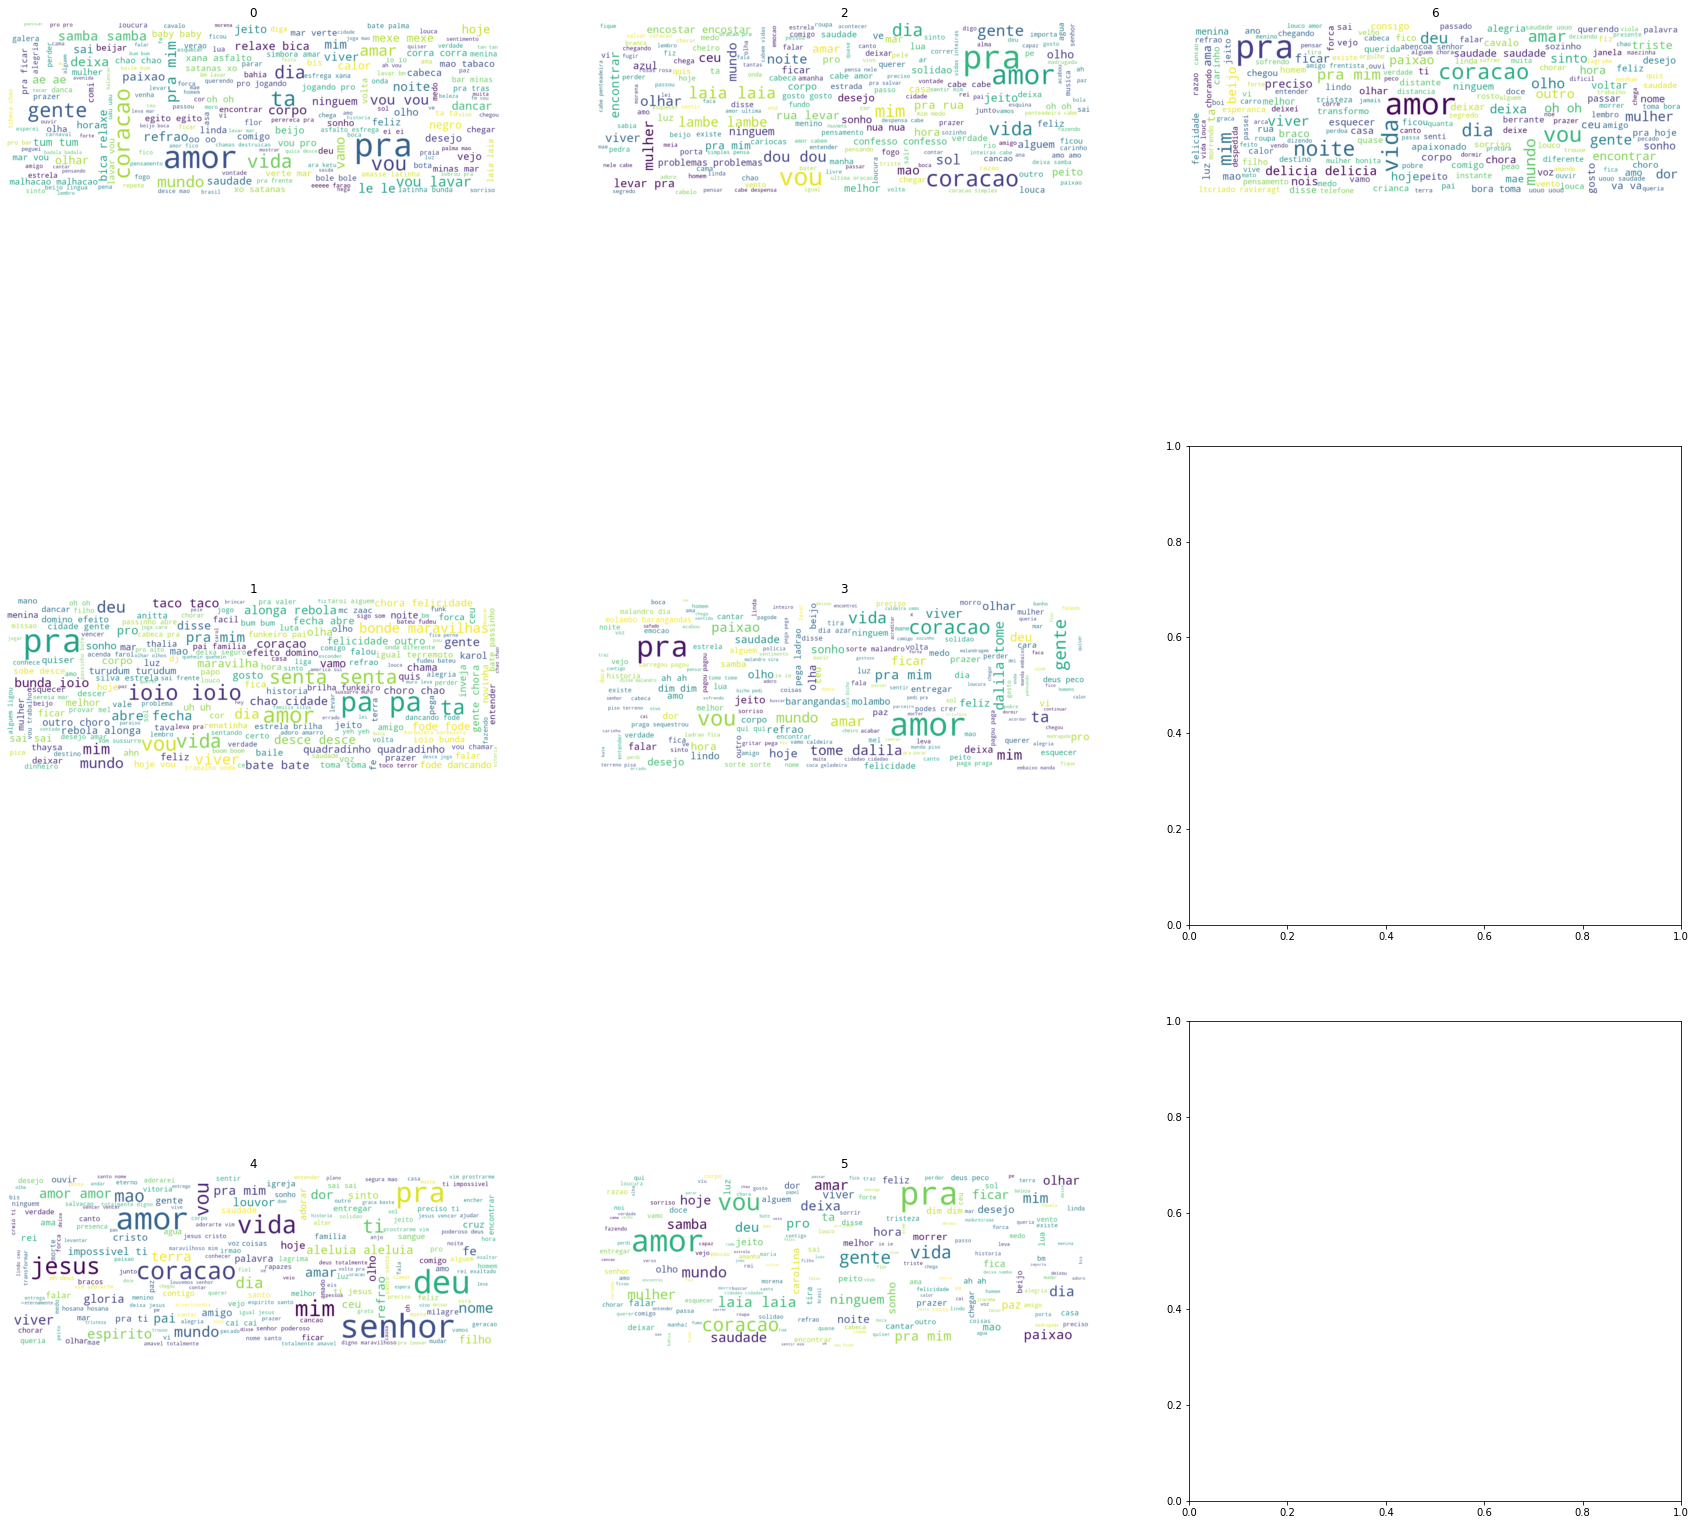

CPU times: user 10.2 s, sys: 969 ms, total: 11.2 s
Wall time: 11.2 s


In [411]:
%%time
categorys = df_br_[df_br_['is_pt'] != "Tradução "]['category'].unique()
rows=3
cols=3
fig, ax = plt.subplots(rows, cols, figsize=(30,30))

row=0 
col=0 
for t in range(len(categorys)):
    text = " ".join(review for review in df_br_[(df_br_['is_pt'] != 'Tradução ') & (df_br_['category'] == categorys[t])]['Transformed'])
    try:
        ax[row][col].imshow(WordCloud(max_font_size=100,width = 1520, height = 535, background_color="white").generate(text), interpolation="bilinear")
        ax[row][col].set_title(categorys[t]) 
        ax[row][col].grid(False) 
        ax[row][col].axis("off")
    
        row=row+1
        if row==rows:
            row=0
            col=col+1
    except:
        pass
    


plt.show() 

Diferentes estilos de musicas ocasionam em uma maior ou menor diversidade de palavras? 

Para responder esta pergunta, foi realizada a redução de palavras duplicadas em cada letra. Para melhor exemplificação:

- Supõe-se que tem uma música que contém 30 palavras, sendo que 5 são duplicadas e outra música que contém 100 palavras e apenas 10 duplicadas. Retirando as duplicidades, tem - se 20 palavras na primeira e 80 na segunda. Neste caso, a segunda música contém uma diversidade maior de palavras utilizadas.

In [311]:
%%time
df_br_['Reduce'] = df_br_['Transformed'].apply(lambda x: ' '.join(unique_list(x.split())))
df_br_['len'] = df_br_['Reduce'].apply(lambda x: len(x))

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 44.1 ms


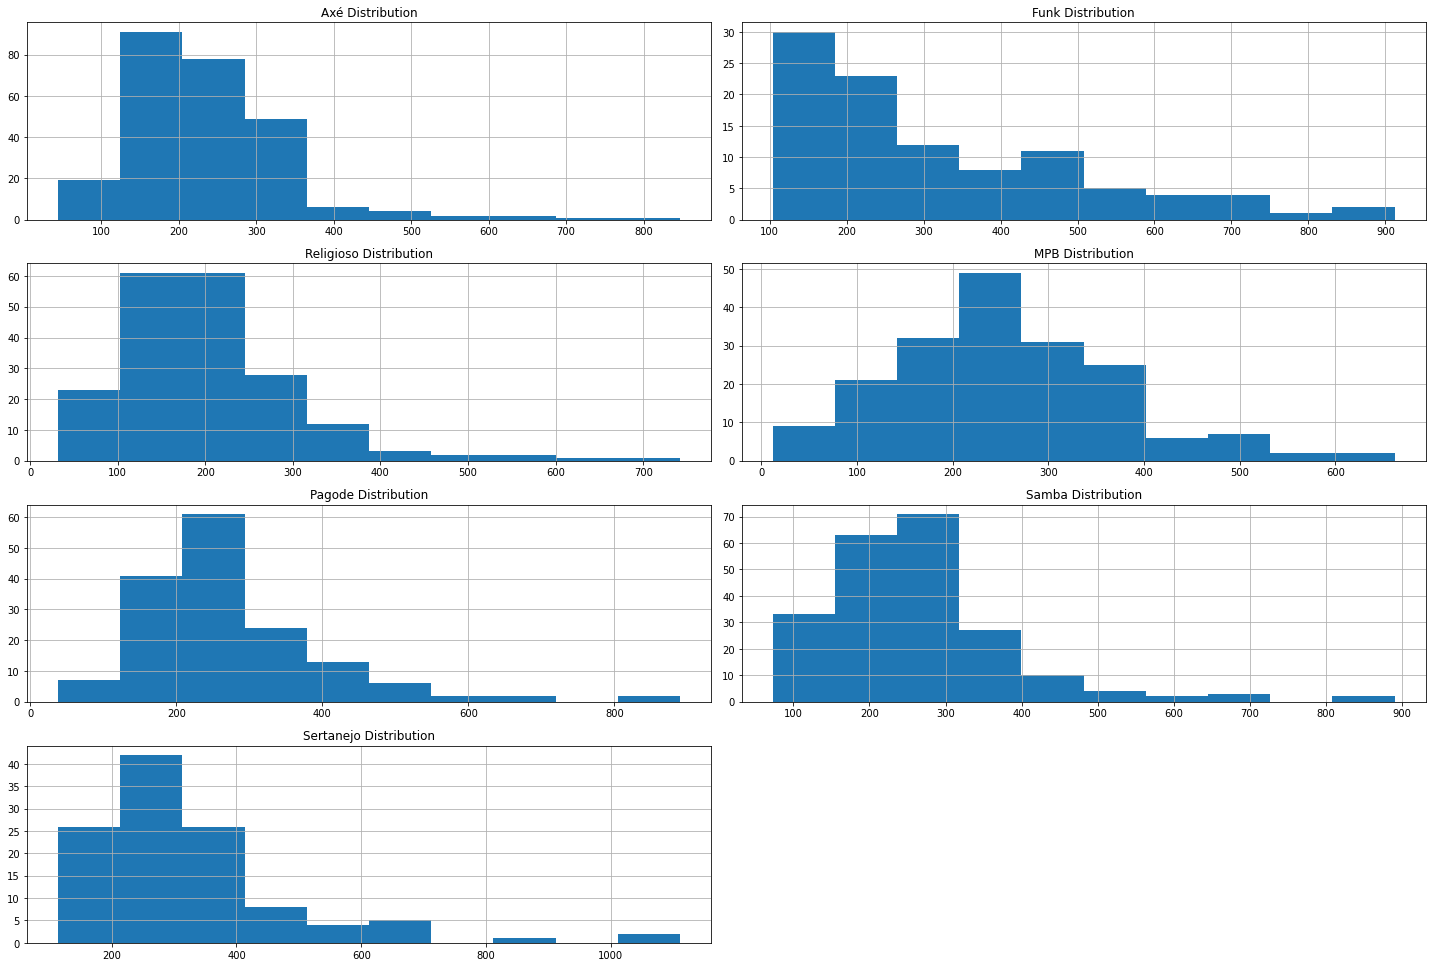

CPU times: user 2.44 s, sys: 516 ms, total: 2.95 s
Wall time: 2.73 s


In [312]:
%%time
categorys = df_br_[df_br_['is_pt'] != "Tradução "]['category'].unique()

def draw_histograms(df, categorys, n_rows, n_cols):
    fig=plt.figure(figsize=(20,20))

    for i, var_name in enumerate(categorys):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[df['category']== var_name]['len'].hist(bins = 10, ax=ax)
        ax.set_title(var_name + " Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(df_br_, categorys, 6, 2)
    

# Aplicando modelos supervisionados

In [313]:
# Transformando rótulos em números
df_br_['fast_category'] = df_br_['category']
le = preprocessing.LabelEncoder()
le.fit(df_br_['category'].unique())
df_br_['category'] = le.transform(df_br_['category'])

In [314]:
# Treino e teste
X_treino, X_valid, y_treino, y_valid = train_test_split(df_br_['Transformed'], df_br_['category'], test_size=0.3)

In [369]:
# Vectorizer
vect = TfidfVectorizer(max_features=60, min_df=2, ngram_range=(1,2))
X_treino_vect = vect.fit_transform(X_treino)
X_valid_vect = vect.fit_transform(X_valid)

### Random Forest

In [370]:
random = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, n_jobs = 6)
random.fit(X_treino_vect.todense(), y_treino)
predictions_random = random.predict(X_valid_vect.todense())

In [371]:
# Matriz de confusão
data = {'y_Actual':    y_valid,
        'y_Predicted': predictions_random}

df_pred = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_pred['y_Actual'], df_pred['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

In [372]:
# Validando modelo
print("F1: ", f1_score(y_valid, predictions_random, average='macro'))
print("ACC: ", accuracy_score(y_valid, predictions_random))
print("Precisão: ", precision_score(y_valid, predictions_random, average='macro'))

F1:  0.12537548094066242
ACC:  0.16666666666666666
Precisão:  0.15215282531745483


### XGBOOST

In [373]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.03, max_depth=1, random_state=0)
clf.fit(X_treino_vect.todense(), y_treino)
predictions_xgboost = clf.predict(X_valid_vect.todense())

In [374]:
# Validando modelo
print("F1: ", f1_score(y_valid, predictions_xgboost, average='macro'))
print("ACC: ", accuracy_score(y_valid, predictions_xgboost))
print("Precisão: ", precision_score(y_valid, predictions_xgboost, average='macro'))

F1:  0.13771501066036748
ACC:  0.15300546448087432
Precisão:  0.13839882995769473


### FastText

In [321]:
# Preparando label
df_br_['fast_category'] = df_br_['fast_category'].apply(lambda x: "__label__" + unidecode(x.lower()))

In [322]:

df_br_.shape[0]*0.7

852.5999999999999

In [323]:
df_br_.shape[0]*0.3

365.4

In [324]:
# Escrevendo base em arquivo txt
with open('../dataset/music.txt', 'w') as f:
    f.write(
        df_br_[['fast_category', 'Transformed']].to_string(header = False, index = False)
    )

In [325]:
# Separando entre treino e teste
os.system('head -n 852 ../dataset/music.txt > ../dataset/music_train.txt')
os.system('tail -n 364 ../dataset/music.txt > ../dataset/music_test.txt')

0

In [367]:
# Treinando modelo
model = fasttext.train_supervised(input="../dataset/music_train.txt", epoch=100, lr=0.335, wordNgrams=3, bucket=200000, dim=60, loss='hs')
model.save_model('model_music.bin')

In [368]:
# Testando
model.test('../dataset/music_test.txt')

(35, 0.34285714285714286, 0.34285714285714286)

# Aplicando regras não supervisionadas